Importing Libraries


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

Loading the dataset

In [542]:
raw_data = pd.read_csv('drive/My Drive/data.csv',index_col=0)
raw_data.head()

match_event_id  location_x  ...  remaining_sec.1  distance_of_shot.1
0            10.0       167.0  ...          54.2000                38.0
1            12.0      -157.0  ...          22.0000                35.0
2            35.0      -101.0  ...          63.7216                54.4
3            43.0       138.0  ...          52.0000                42.0
4           155.0         0.0  ...          19.0000                20.0

[5 rows x 27 columns]

**Exploratory Data Analysis**

In [543]:
# Checking for missing values
raw_data.isnull().sum()

match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number            1563
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

Bivariate Analysis

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


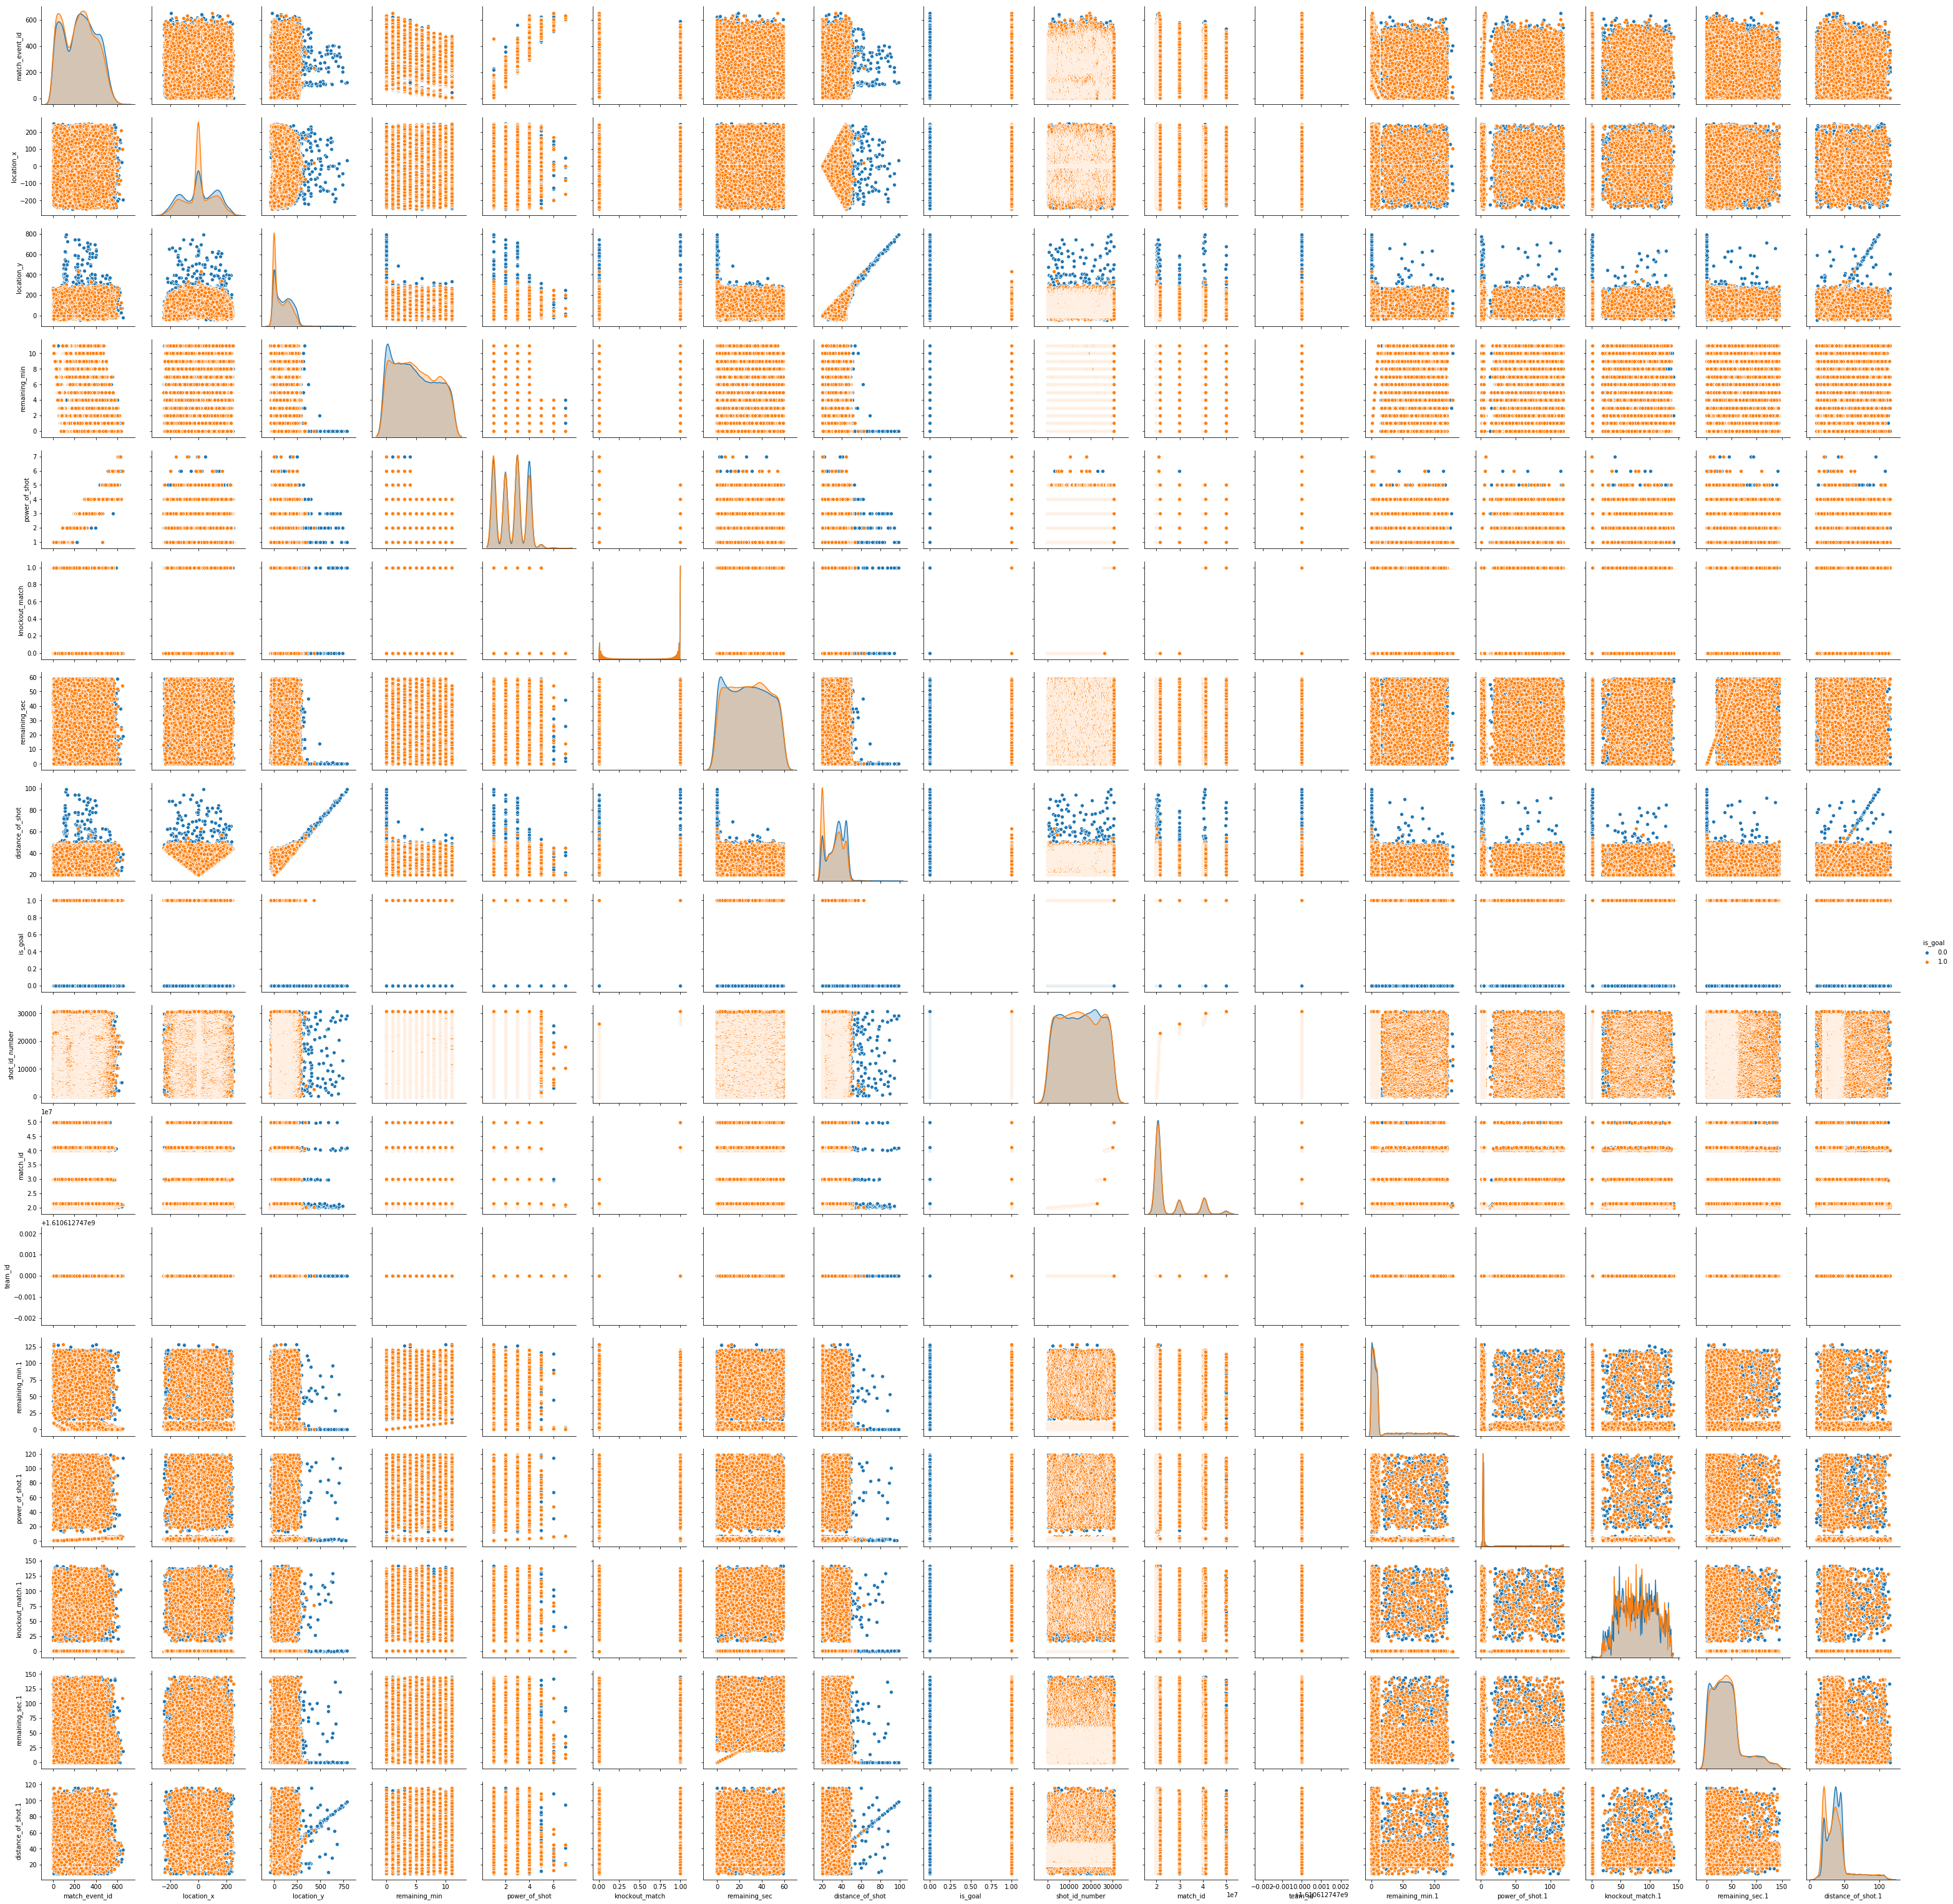

In [545]:
sns.pairplot(raw_data,hue='is_goal')
plt.show()

Missing values treatment

In [361]:
raw_data.team_id.value_counts()

1610612747    30697
Name: team_id, dtype: int64

In [0]:
# drop columns which do not contribute to predictions
raw_data.drop('match_event_id',inplace=True,axis=1)
raw_data.drop('team_name',inplace=True,axis=1)
raw_data.drop('date_of_game',inplace=True,axis=1)
raw_data.drop('lat/lng',inplace=True,axis=1)
raw_data.drop('team_id',inplace=True,axis=1)

In [465]:
raw_data.shape

(30697, 22)

In [466]:
# Filling missing shot_id_numbers
raw_data.shot_id_number.interpolate(inplace=True)
# checking for null values
raw_data.shot_id_number.isnull().sum()

0

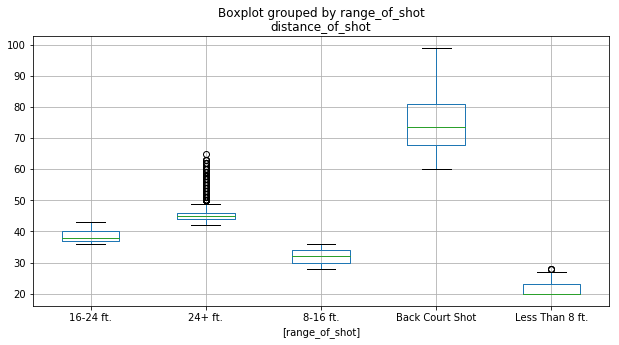

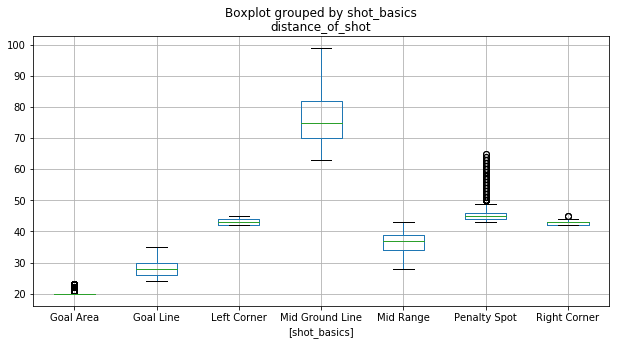

In [390]:
raw_data.boxplot(figsize = [10,5],column='distance_of_shot',by=['range_of_shot'])
raw_data.boxplot(figsize = [10,5],column='distance_of_shot',by=['shot_basics'])

In [0]:
table2 = raw_data.pivot_table(values='distance_of_shot' ,columns='range_of_shot', aggfunc=np.median)
table1 = raw_data.pivot_table(values='distance_of_shot' ,columns='shot_basics', aggfunc=np.median)
# Define function to return value of this pivot_table 
def fage(x):
  if str(x['shot_basics']) != 'nan':
    return table1.loc['distance_of_shot',x['shot_basics']]
  elif str(x['range_of_shot'])!= 'nan':
    return table2.loc['distance_of_shot',x['range_of_shot']]
  else:
    return x['distance_of_shot.1']
# Replace missing values 
raw_data['distance_of_shot'].fillna(raw_data[raw_data['distance_of_shot'].isnull()].apply(fage, axis=1), inplace=True)

In [0]:
raw_data = raw_data[raw_data['distance_of_shot'].notnull()]

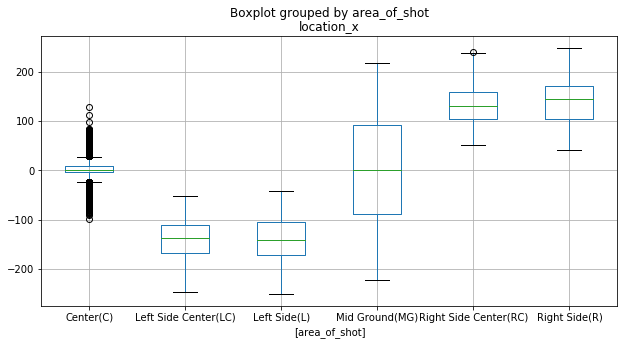

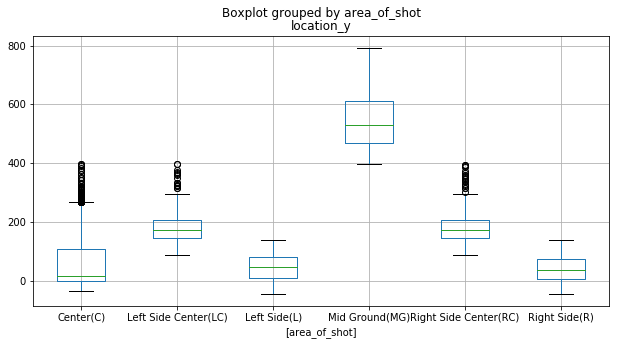

In [393]:
raw_data.boxplot(figsize = [10,5],column='location_x',by=['area_of_shot'])
raw_data.boxplot(figsize = [10,5],column='location_y',by=['area_of_shot'])

In [0]:
table = raw_data.pivot_table(values=['location_x','location_y'] ,columns='area_of_shot', aggfunc=np.median)
def lacx(x):
  if str(x['area_of_shot']) != 'nan':
    return table.loc['location_x',x['area_of_shot']]
  else:
    return None
def lacy(x):
  if str(x['area_of_shot']) != 'nan':
    return table.loc['location_y',x['area_of_shot']]
  else:
    return None

raw_data['location_x'].fillna(raw_data[raw_data['location_x'].isnull()].apply(lacx, axis=1), inplace=True)
raw_data['location_y'].fillna(raw_data[raw_data['location_y'].isnull()].apply(lacy, axis=1), inplace=True)

In [0]:
raw_data['location_x'].fillna(raw_data['location_x'].median(), inplace=True)
raw_data['location_y'].fillna(raw_data['location_y'].median(), inplace=True)

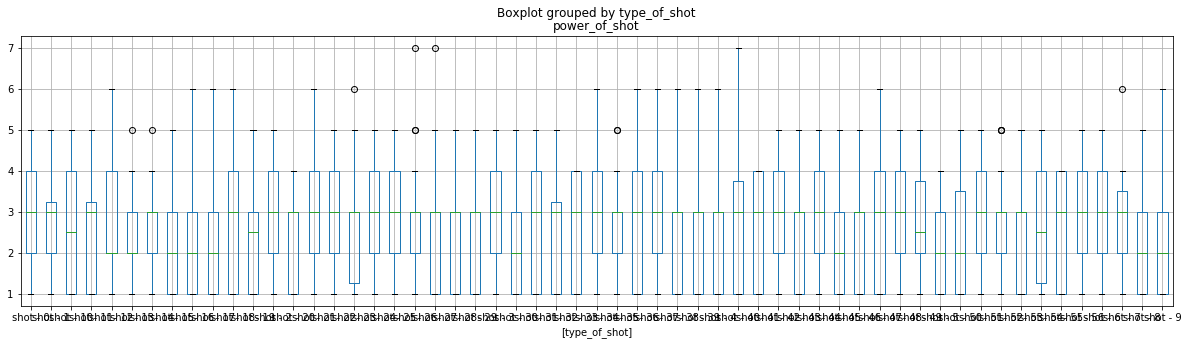

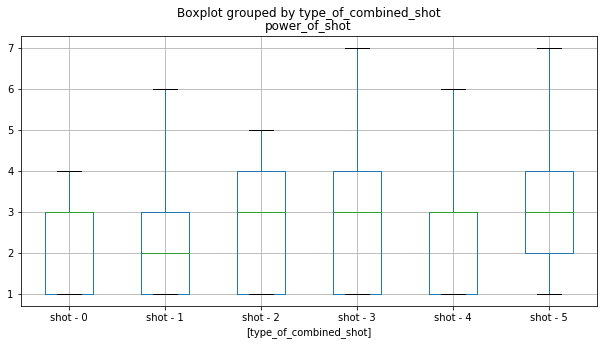

In [347]:
raw_data.boxplot(figsize = [20,5],column='power_of_shot',by=['type_of_shot'])
raw_data.boxplot(figsize = [10,5],column='power_of_shot',by=['type_of_combined_shot'])

In [471]:
table1 = raw_data.pivot_table(values= 'power_of_shot' ,columns='type_of_shot', aggfunc=np.median)
table2 = raw_data.pivot_table(values= 'power_of_shot' ,columns='type_of_combined_shot', aggfunc=np.median)
def powerofshot(x):
  if str(x['power_of_shot.1']) != 'nan' and x['power_of_shot.1']<=7.0:
    return x['power_of_shot.1']
  elif str(x['type_of_shot']) != 'nan':
    return table1.loc['power_of_shot',x['type_of_shot']]
  else:
    return table2.loc['power_of_shot',x['type_of_combined_shot']]
  
raw_data['power_of_shot'].fillna(raw_data[raw_data['power_of_shot'].isnull()].apply(powerofshot, axis=1), inplace=True)
raw_data['power_of_shot'].isnull().sum()

0

In [472]:
mapp = pd.Series(raw_data['shot_basics'].values,index=raw_data['range_of_shot']).to_dict()
raw_data.pivot_table(values='is_goal',index=['shot_basics'],aggfunc=lambda x: x.mean())

is_goal
shot_basics              
Goal Area        0.618073
Goal Line        0.453485
Left Corner      0.365741
Mid Ground Line  0.017544
Mid Range        0.406092
Penalty Spot     0.334040
Right Corner     0.334437

In [473]:
raw_data['shot_basics'].value_counts()

Mid Range          11955
Goal Area           6787
Penalty Spot        5321
Goal Line           4357
Right Corner         367
Left Corner          268
Mid Ground Line       67
Name: shot_basics, dtype: int64

In [474]:
def shotbasics(x):
  if str(x['range_of_shot']) != 'nan':
    return mapp[x['range_of_shot']]
  else:
    return 'Mid Range'
  
raw_data['shot_basics'].fillna(raw_data[raw_data['shot_basics'].isnull()].apply(shotbasics, axis=1), inplace=True)
raw_data['shot_basics'].isnull().sum()

0

In [0]:
# drop useless columns
raw_data.drop('area_of_shot',inplace=True,axis=1)
raw_data.drop('range_of_shot',inplace=True,axis=1)
raw_data.drop('remaining_min.1',inplace=True,axis=1)
raw_data.drop('remaining_sec.1',inplace=True,axis=1)
raw_data.drop('power_of_shot.1',inplace=True,axis=1)
raw_data.drop('knockout_match.1',inplace=True,axis=1)
raw_data.drop('distance_of_shot.1',inplace=True,axis=1)

In [476]:
ko = pd.Series(raw_data['knockout_match'].values,index=raw_data['match_id']).to_dict()
def kom(x):
  return ko[x['match_id']]

raw_data['knockout_match'].fillna(raw_data[raw_data['knockout_match'].isnull()].apply(kom, axis=1), inplace=True)
raw_data['knockout_match'].fillna(0, inplace=True)
raw_data['knockout_match'].isnull().sum()


0

In [477]:
gs = pd.Series(raw_data['game_season'].values,index=raw_data['match_id']).to_dict()
def gss(x):
  return gs[x['match_id']]

raw_data['game_season'].fillna(raw_data[raw_data['game_season'].isnull()].apply(gss, axis=1), inplace=True)
raw_data['game_season'].fillna(method='ffill',inplace=True)
raw_data['game_season'].isnull().sum()


0

In [478]:
ha = pd.Series(raw_data['home/away'].values,index=raw_data['match_id']).to_dict()
def home(x):
  return ha[x['match_id']]

raw_data['home/away'].fillna(raw_data[raw_data['home/away'].isnull()].apply(home, axis=1), inplace=True)
raw_data['home/away'].fillna(method='ffill',inplace=True)
raw_data['home/away'].isnull().sum()


0

In [0]:
# drop columns which are not useful
raw_data.drop('remaining_min',inplace=True,axis=1)
raw_data.drop('remaining_sec',inplace=True,axis=1)

In [480]:
raw_data.shape

(30696, 13)

In [0]:
raw_data['type_of_shot'].fillna('',inplace=True)
raw_data['type_of_combined_shot'].fillna('',inplace=True)

**Converting categorial  Variables**

Dummy variables are added to the dataframe to represent categorial variable as categorical variables are unsuitable for logistic regression model.

In [0]:
# crete dummy variable for home game
raw_data['Home'] = raw_data['home/away'].str.contains('vs').map({True:1,False:0})
raw_data.drop('home/away',inplace=True,axis=1)

In [0]:
# create dummy variable for game_season
game_seasons = pd.get_dummies(raw_data['game_season'])
raw_data = pd.concat([raw_data, game_seasons], axis=1)
raw_data.drop('game_season',inplace=True,axis=1)

In [0]:
# create dummy variable for shot_basics
shot_basics = pd.get_dummies(raw_data['shot_basics'])
raw_data = pd.concat([raw_data, shot_basics], axis=1)
raw_data.drop('shot_basics',inplace=True,axis=1)

In [0]:
# create dummy variable for type_of_shot
shot_types = pd.get_dummies(raw_data['type_of_shot'])
raw_data = pd.concat([raw_data, shot_types], axis=1)
raw_data.drop(['type_of_shot',''],inplace=True,axis=1)

In [0]:
# create dummy variable for type_of_combined_shot
shot_types = pd.get_dummies(raw_data['type_of_combined_shot'],prefix='c')
raw_data = pd.concat([raw_data, shot_types], axis=1)
raw_data.drop(['type_of_combined_shot','c_'],inplace=True,axis=1)

In [489]:
raw_data.drop('match_id',inplace=True,axis=1)
raw_data.columns

Index(['location_x', 'location_y', 'power_of_shot', 'knockout_match',
       'distance_of_shot', 'is_goal', 'shot_id_number', 'Home', '1996-97',
       '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
       '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
       '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
       '2015-16', 'Goal Area', 'Goal Line', 'Left Corner', 'Mid Ground Line',
       'Mid Range', 'Penalty Spot', 'Right Corner', 'shot - 0', 'shot - 1',
       'shot - 10', 'shot - 11', 'shot - 12', 'shot - 13', 'shot - 14',
       'shot - 15', 'shot - 16', 'shot - 17', 'shot - 18', 'shot - 19',
       'shot - 2', 'shot - 20', 'shot - 21', 'shot - 22', 'shot - 23',
       'shot - 24', 'shot - 25', 'shot - 26', 'shot - 27', 'shot - 28',
       'shot - 29', 'shot - 3', 'shot - 30', 'shot - 31', 'shot - 32',
       'shot - 33', 'shot - 34', 'shot - 35', 'shot - 36', 'shot - 37',
       'shot - 38', 'shot - 39', 'shot - 4', 'shot -

In [490]:
# all missing values filled
raw_data.isnull().sum()

location_x             0
location_y             0
power_of_shot          0
knockout_match         0
distance_of_shot       0
is_goal             6268
shot_id_number         0
Home                   0
1996-97                0
1997-98                0
1998-99                0
1999-00                0
2000-01                0
2001-02                0
2002-03                0
2003-04                0
2004-05                0
2005-06                0
2006-07                0
2007-08                0
2008-09                0
2009-10                0
2010-11                0
2011-12                0
2012-13                0
2013-14                0
2014-15                0
2015-16                0
Goal Area              0
Goal Line              0
                    ... 
shot - 39              0
shot - 4               0
shot - 40              0
shot - 41              0
shot - 42              0
shot - 43              0
shot - 44              0
shot - 45              0
shot - 46              0


In [0]:
# Converting distace of shot to log scale for outlier removal
raw_data['distance_of_shot'] = np.log10(1+raw_data['distance_of_shot'])

In [492]:
raw_data.set_index('shot_id_number', inplace=True)
raw_data.head(10)

location_x  location_y  ...  c_shot - 4  c_shot - 5
shot_id_number                          ...                        
1.0                  167.0        72.0  ...           0           0
2.0                 -157.0         0.0  ...           0           0
3.0                 -101.0       135.0  ...           0           0
4.0                  138.0       175.0  ...           0           0
5.0                    0.0         0.0  ...           0           0
6.0                 -145.0       -11.0  ...           0           0
7.0                    0.0         0.0  ...           1           0
8.0                    1.0        28.0  ...           0           0
9.0                  -65.0        45.0  ...           0           0
10.0                 -33.0        15.0  ...           0           0

[10 rows x 97 columns]

In [0]:
Y = raw_data['is_goal'].reset_index()
X = raw_data.loc[:,raw_data.columns != 'is_goal']

Normalisation

In [504]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
print(X.shape,Y.shape)

(30696, 96) (30696, 2)


In [506]:
X['is_goal'] = Y['is_goal']
X['shot_id_number'] = Y['shot_id_number']
X.head()

0         1         2    3  ...   94   95  is_goal  shot_id_number
0  0.837349  0.138922  0.000000  0.0  ...  0.0  0.0      NaN             1.0
1  0.186747  0.052695  0.000000  0.0  ...  0.0  0.0      0.0             2.0
2  0.299197  0.214371  0.000000  0.0  ...  0.0  0.0      1.0             3.0
3  0.779116  0.262275  0.000000  0.0  ...  0.0  0.0      0.0             4.0
4  0.502008  0.052695  0.166667  0.0  ...  0.0  0.0      1.0             5.0

[5 rows x 98 columns]

In [507]:

train = X[X.is_goal.notnull()]
test = X[X.is_goal.isnull()]
print(train.shape)
print(test.shape)

(24428, 98)
(6268, 98)


In [0]:
train = train.set_index('shot_id_number')
test = test.set_index('shot_id_number')

In [0]:
# Saving the cleaned train and test data
train.to_csv('train.csv')
test.to_csv('test.csv')

In [516]:
train.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39,        40,        41,
              42,        43,        44,        45,        46,        47,
              48,        49,        50,        51,        52,        53,
              54,        55,        56,        57,        58,        59,
              60,        61,        62,        63,        64,        65,
              66,        67,        68,        69,        70,        71,
              72,        73,        74,        75,        76,        77,
              78,        79,        80,        81, 

In [514]:
# Splitting the train and test data into x and y for logit
Y_train = np.array(train['is_goal'])
X_train = np.array(train.loc[:,train.columns != 'is_goal'])
X_test = np.array(test.loc[:,test.columns != 'is_goal'])
print(X_train.shape,Y_train.shape,X_test.shape)


(24428, 96) (24428,) (6268, 96)


In [518]:
X_test

array([[0.8373494 , 0.13892216, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50401606, 0.08622754, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [0.50200803, 0.05269461, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.53413655, 0.16407186, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.58232932, 0.17245509, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.50200803, 0.05269461, 0.5       , ..., 0.        , 0.        ,
        0.        ]])

**Model Building and Predictions**

In [520]:
model = LogisticRegression(random_state=0)
model.fit(X_train,Y_train) #Training

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
results = model.predict_proba(X_test)[:,0] #Predicting

In [0]:
# Saving the model

submission = pd.DataFrame()
submission['shot_id_number'] = test.reset_index()['shot_id_number'].astype(int)
submission['is_goal'] = pd.Series(results)
submission.to_csv('navodit_jain_311298_prediction_3.csv',index=False)